**NOTE: GitHub doesn't render the GIF animations in this notebook. View this locally or in nbviewer for best results.**

[![Nbviewer](https://img.shields.io/badge/render-nbviewer-lightgrey?logo=jupyter)](https://nbviewer.jupyter.org/github/stefmolin/python-data-viz-workshop/blob/main/notebooks/2-animations.ipynb) [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/stefmolin/python-data-viz-workshop/main?urlpath=lab/tree/notebooks/2-animations.ipynb) [![View slides in browser](https://img.shields.io/badge/view-slides-orange?logo=reveal.js&logoColor=white)](https://stefaniemolin.com/python-data-viz-workshop/#/section-2)

---

# Section 2: Moving Beyond Static Visualizations

Static visualizations are limited in how much information they can show. To move beyond these limitations, we can create animated and/or interactive visualizations. Animations make it possible for our visualizations to tell a story through movement of the plot components (e.g., bars, points, lines). Interactivity makes it possible to explore the data visually by hiding and displaying information based on user interest. In this section, we will focus on creating animated visualizations using Matplotlib before moving on to create interactive visualizations in the next section.

## Animating cumulative values over time

In the previous section, we made a couple of visualizations to help us understand the number of Stack Overflow questions per library and how it changed over time. However, each of these came with some limitations.

We made a bar plot that captured the total number of questions per library, but it couldn't show us the growth in pandas questions over time (or how the growth rate changed over time):

<div style="text-align: center;">
    <img width="60%" src="https://raw.githubusercontent.com/stefmolin/python-data-viz-workshop/main/media/bar_plot.svg" alt="bar plot" style="min-width: 500px">
</div>

We also made an area plot showing the number of questions per day over time for the top 4 libraries, but by limiting the libraries shown we lost some information:

<div style="text-align: center;">
    <img width="90%" src="https://raw.githubusercontent.com/stefmolin/python-data-viz-workshop/main/media/area_plot.svg" alt="area plot" style="min-width: 600px">
</div>

Both of these visualizations gave us insight into the dataset. For example, we could see that pandas has by far the largest number of questions and has been growing at a faster rate than the other libraries. While this comes from studying the plots, an animation would make this much more obvious and, at the same time, capture the exponential growth in pandas questions that helped pandas overtake both Matplotlib and NumPy in cumulative questions.

Let's use Matplotlib to create an animated bar plot of cumulative questions over time to show this. We will do so in the following steps:
1. Create a dataset of cumulative questions per library over time.
2. Import the `FuncAnimation` class.
3. Write a function for generating the initial plot.
4. Write a function for generating annotations and plot text.
5. Define the plot update function.
6. Bind arguments to the update function.
7. Animate the plot.

#### 1. Create a dataset of cumulative questions per library over time.
We will start by reading in our Stack Overflow dataset, but this time, we will calculate the total number of questions per month and then calculate the cumulative value over time:

In [1]:
import pandas as pd

questions_per_library = pd.read_csv(
    '../data/stackoverflow.zip', parse_dates=True, index_col='creation_date'
).loc[:,'pandas':'bokeh'].resample('1ME').sum().cumsum().reindex(
    pd.date_range('2008-08', '2021-10', freq='ME')
).fillna(0)
questions_per_library.tail()

,pandas,matplotlib,numpy,seaborn,geopandas,geoviews,altair,yellowbrick,vega,holoviews,hvplot,bokeh
2021-05-31,200734.0,57853.0,89812.0,6855.0,1456.0,57.0,716.0,46.0,532.0,513.0,84.0,4270.0
2021-06-30,205065.0,58602.0,91026.0,7021.0,1522.0,57.0,760.0,48.0,557.0,521.0,88.0,4308.0
2021-07-31,209235.0,59428.0,92254.0,7174.0,1579.0,62.0,781.0,50.0,572.0,528.0,89.0,4341.0
2021-08-31,213410.0,60250.0,93349.0,7344.0,1631.0,62.0,797.0,52.0,589.0,541.0,92.0,4372.0
2021-09-30,214919.0,60554.0,93797.0,7414.0,1652.0,63.0,804.0,54.0,598.0,542.0,92.0,4386.0


*Source: [Stack Exchange Network](https://api.stackexchange.com/docs/search)*

#### 2. Import the `FuncAnimation` class.
To create animations with Matplotlib, we will be using the `FuncAnimation` class, so let's import it now:

In [2]:
from matplotlib.animation import FuncAnimation

At a minimum, we will need to provide the following when instantiating a `FuncAnimation` object:
- The `Figure` object to draw on.
- A function to call at each frame to update the plot.

In the next few steps, we will work on the logic for these.

#### 3. Write a function for generating the initial plot.
Since we are required to pass in a `Figure` object and bake all the plot update logic into a function, we will start by building up an initial plot. Here, we create a bar plot with bars of width 0, so that they don't show up for now. The y-axis is set up so that the libraries with the most questions overall are at the top:

In [3]:
import matplotlib.pyplot as plt
from matplotlib import ticker
from utils import despine


def bar_plot(data):
    fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
    sort_order = data.loc[data.index.max()].sort_values().index
    bars = ax.barh(sort_order, [0] * data.shape[1], label=sort_order)
    
    ax.set_xlabel('total questions', fontweight='bold')
    ax.set_xlim(0, 250_000)
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.xaxis.set_tick_params(labelsize=11)
    ax.yaxis.set_tick_params(labelsize=11)
    despine(ax)

    return fig, ax

This gives us a plot that we can update:

(<Figure size 600x400 with 1 Axes>, <Axes: xlabel='total questions'>)

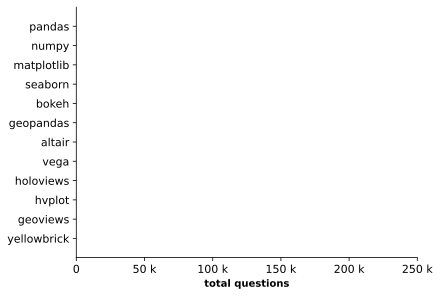

In [4]:
import matplotlib_inline
from utils import mpl_svg_config

matplotlib_inline.backend_inline.set_matplotlib_formats(
    'svg', **mpl_svg_config('section-2')
)
bar_plot(questions_per_library)

#### 4. Write a function for generating annotations and plot text.

We will also need to initialize annotations for each of the bars and some text to show the date in the animation (month and year):

In [5]:
def generate_plot_text(ax):
    annotations = [
        ax.annotate(
            '', xy=(0, bar.get_y() + bar.get_height() / 2), ha='left', va='center'
        )
        for bar in ax.patches
    ]

    time_text = ax.text(
        0.9, 0.1, '', transform=ax.transAxes, fontsize=15, ha='center', va='center'
    )
    return annotations, time_text

*Tip: We are passing in `transform=ax.transAxes` when we place our time text in order to specify the location in terms of the `Axes` object's coordinates instead of basing it off the data in the plot so that it is easier to place.*

#### 5. Define the plot update function.

Next, we will make our plot update function. This will be called at each frame. We will extract that frame's data (the cumulative questions for that month), and then update the width of each of the bars. In addition, we will annotate the bars if their widths are greater than 0. At every frame, we will also need to update our time annotation (`time_text`):

In [6]:
def update(frame, *, ax, df, annotations, time_text):
    data = df.loc[frame, :]
    
    # update bars
    for rect, text in zip(ax.patches, annotations):
        col = rect.get_label()
        if data[col]:
            rect.set_width(data[col])
            text.set_x(data[col])
            text.set_text(f' {data[col]:,.0f}')

    # update time
    time_text.set_text(frame.strftime('%b\n%Y'))

*Tip: The asterisk in the function signature requires all arguments after it to be passed in by name. This makes sure that we explicitly define the components for the animation when calling the function. Read more on this syntax [here](https://www.python.org/dev/peps/pep-3102/).*

#### 6. Bind arguments to the update function.

The last step before creating our animation is to create a function that will assemble everything we need to pass to `FuncAnimation`. Note that our `update()` function requires multiple parameters, but we would be passing in the same values every time (since we would only change the value for `frame`). To make this simpler, we create a [partial function](https://docs.python.org/3/library/functools.html#functools.partial), which **binds** values to each of those arguments so that we only have to pass in `frame` when we call the partial. This is essentially a [closure](https://www.programiz.com/python-programming/closure), where `bar_plot_init()` is the enclosing function and `update()` is the nested function, which we defined in the previous code block for readability:

In [7]:
from functools import partial

def bar_plot_init(questions_per_library):
    fig, ax = bar_plot(questions_per_library)
    annotations, time_text = generate_plot_text(ax)

    bar_plot_update = partial(
        update, ax=ax, df=questions_per_library,
        annotations=annotations, time_text=time_text
    )

    return fig, bar_plot_update

#### 7. Animate the plot.
Finally, we are ready to create our animation. We start by calling the `bar_plot_init()` function from the previous code block to generate the `Figure` object and partial function for the update of the plot. Then, we pass in the `Figure` object and update function when initializing our `FuncAnimation` object. We also specify the `frames` argument as the index of our DataFrame (the dates) and that the animation shouldn't repeat because we will save it as an MP4 video:

In [8]:
fig, update_func = bar_plot_init(questions_per_library)

ani = FuncAnimation(
    fig, update_func, frames=questions_per_library.index, repeat=False
)
ani.save(
    '../media/stackoverflow_questions.mp4', 
    writer='ffmpeg', fps=10, bitrate=100, dpi=300
)
plt.close()

**Important**: The `FuncAnimation` object **must** be assigned to a variable when creating it; otherwise, without any references to it, Python will garbage collect it &ndash; ending the animation. For more information on garbage collection in Python, check out [this](https://stackify.com/python-garbage-collection/) article.

Now, let's view the animation we just saved as an MP4 file:

In [9]:
from IPython import display

display.Video(
    '../media/stackoverflow_questions.mp4', width=600, height=400,
    embed=True, html_attributes='controls muted autoplay'
)

## Animating distributions over time

As with the previous example, the histograms of daily Manhattan subway entries in 2018 (from the first section of the workshop) don't tell the whole story of the dataset because the distributions changed drastically in 2020 and 2021:

<div style="text-align: center;">
    <img width="70%" src="https://raw.githubusercontent.com/stefmolin/python-data-viz-workshop/main/media/2018_subway_entries_histogram.svg" alt="Histograms of daily Manhattan subway entries in 2018" style="min-width: 500px">
</div>

We will make an animated version of these histograms that enables us to see the distributions changing over time. Note that this example will have two key differences from the previous one. The first is that we will be animating subplots rather than a single plot, and the second is that we will use a technique called **blitting** to only update the portion of the subplots that has changed. This requires that we return the [*artists*](https://matplotlib.org/stable/tutorials/intermediate/artists.html) that need to be redrawn in the plot update function.

To make this visualization, we will work through these steps:

1. Create a dataset of daily subway entries.
2. Determine the bin ranges for the histograms.
3. Write a function for generating the initial histogram subplots.
4. Write a function for generating an annotation for the time period.
5. Define the plot update function.
6. Bind arguments for the update function.
7. Animate the plot.

#### 1. Create a dataset of daily subway entries.
As we did previously, we will read in the subway dataset, which contains the total entries and exits per day per borough:

In [10]:
subway = pd.read_csv(
    '../data/NYC_subway_daily.csv', parse_dates=['Datetime'], 
    index_col=['Borough', 'Datetime']
)
subway_daily = subway.unstack(0)
subway_daily.head()

Entries                                    Exits            \
Borough            Bk        Bx          M         Q        Bk        Bx   
Datetime                                                                   
2017-02-04   617650.0  247539.0  1390496.0  408736.0  417449.0  148237.0   
2017-02-05   542667.0  199078.0  1232537.0  339716.0  405607.0  139856.0   
2017-02-06  1184916.0  472846.0  2774016.0  787206.0  761166.0  267991.0   
2017-02-07  1192638.0  470573.0  2892462.0  790557.0  763653.0  270007.0   
2017-02-08  1243658.0  497412.0  2998897.0  825679.0  788356.0  275695.0   

                                 
Borough             M         Q  
Datetime                         
2017-02-04  1225689.0  279699.0  
2017-02-05  1033610.0  268626.0  
2017-02-06  2240027.0  537780.0  
2017-02-07  2325024.0  544828.0  
2017-02-08  2389534.0  559639.0

*Source: The above dataset was resampled from [this](https://www.kaggle.com/eddeng/nyc-subway-traffic-data-20172021?select=NYC_subway_traffic_2017-2021.csv) dataset provided by Kaggle user [Edden](https://www.kaggle.com/eddeng).*

For this visualization, we will just be working with the entries in Manhattan:

In [11]:
manhattan_entries = subway_daily['Entries']['M']

#### 2. Determine the bin ranges for the histograms.
Before we can set up the subplots, we have to calculate the bin ranges for the histograms so that our animation is smooth. NumPy provides the `histogram()` function, which gives us both the number of data points in each bin and the bin ranges, respectively. We will also be using this function to update the histograms during the animation:

In [12]:
import numpy as np

count_per_bin, bin_ranges = np.histogram(manhattan_entries, bins=30)

#### 3. Write a function for generating the initial histogram subplots.

Next, we will handle the logic for building our initial histogram, packaging it in a function:

In [13]:
def subway_histogram(data, bins, date_range):
    _, bin_ranges = np.histogram(data, bins=bins)

    weekday_mask = data.index.weekday < 5
    configs = [
        {'label': 'Weekend', 'mask': ~weekday_mask, 'ymax': 60},
        {'label': 'Weekday', 'mask': weekday_mask, 'ymax': 120}
    ]
    
    fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharex=True, layout='constrained')
    for ax, config in zip(axes, configs):
        _, _, config['hist'] = ax.hist(
            data[config['mask']].loc[date_range], bin_ranges, ec='black'
        )
        ax.xaxis.set_major_formatter(ticker.EngFormatter())
        ax.set(
            xlim=(0, None), ylim=(0, config['ymax']),
            xlabel=f'{config["label"]} Entries'
        )
        despine(ax)

    axes[0].set_ylabel('Frequency')
    fig.suptitle('Histogram of Daily Subway Entries in Manhattan')

    return fig, axes, bin_ranges, configs

Notice that our plot this time starts out with data already &ndash; this is because we want to show the change in the distribution of daily entries in the last year:

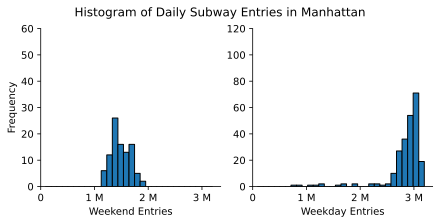

In [14]:
_ = subway_histogram(manhattan_entries, bins=30, date_range='2017')

#### 4. Write a function for generating an annotation for the time period.

We will once again include some text that indicates the time period as the animation runs. This is similar to what we had in the previous example:

In [15]:
def add_time_text(ax):
    time_text = ax.text(
        0.15, 0.9, '', transform=ax.transAxes,
        fontsize=12, ha='center', va='center'
    )
    return time_text

#### 5. Define the plot update function.

Now, we will create our update function. This time, we have to update both subplots and return any artists that need to be redrawn since we are going to use blitting:

In [16]:
def update(frame, *, data, configs, time_text, bin_ranges):
    artists = []

    time = frame.strftime('%b\n%Y')
    if time != time_text.get_text():
        time_text.set_text(time)
        artists.append(time_text)

    for config in configs:
        time_frame_mask = \
            (data.index > frame - pd.Timedelta(days=365)) & (data.index <= frame)
        counts, _ = np.histogram(
            data[time_frame_mask & config['mask']],
            bin_ranges
        )
        for count, rect in zip(counts, config['hist'].patches):
            if count != rect.get_height():
                rect.set_height(count)
                artists.append(rect)

    return artists

#### 6. Bind arguments for the update function.

As our final step before generating the animation, we bind our arguments to the update function using a partial function:

In [17]:
def histogram_init(data, bins, initial_date_range):
    fig, axes, bin_ranges, configs = subway_histogram(data, bins, initial_date_range)

    update_func = partial(
        update, data=data, configs=configs,
        time_text=add_time_text(axes[0]),
        bin_ranges=bin_ranges
    )

    return fig, update_func

#### 7. Animate the plot.
Finally, we will animate the plot using `FuncAnimation` like before. Notice that this time we are passing in `blit=True`, so that only the artists that we returned in the `update()` function are redrawn. We are specifying to make updates for each day in the data starting on August 1, 2019:

In [18]:
fig, update_func = histogram_init(
    manhattan_entries, bins=30, initial_date_range=slice('2017', '2019-07')
)

ani = FuncAnimation(
    fig, update_func, frames=manhattan_entries['2019-08':'2021'].index,
    repeat=False, blit=True
)
ani.save(
    '../media/subway_entries_subplots.mp4',
    writer='ffmpeg', fps=30, bitrate=500, dpi=300
)
plt.close()

*Tip: We are using a `slice` object to pass a date range for pandas to use with `loc[]`. More information on `slice()` can be found [here](https://docs.python.org/3/library/functions.html?highlight=slice#slice).*

Our animation makes it easy to see the change in the distributions over time:

In [19]:
from IPython import display

display.Video(
    '../media/subway_entries_subplots.mp4', width=600, height=300,
    embed=True, html_attributes='controls muted autoplay'
)

### [Exercise 2.1](./workbook.ipynb#Exercise-2.1)

##### Modify the animation of daily subway entries to show both the weekday and weekend histograms on the same subplot (you only need one now). Don't forget to change the transparency of the bars to be able to visualize the overlap.

In [20]:
# Complete this exercise in the `workbook.ipynb` file

In [21]:
# Click on `Exercise 2.1` above to open the `workbook.ipynb` file

In [22]:
#

In [23]:
#

In [24]:
# WARNING: if you complete the exercise here, your cell numbers
# for the rest of the workshop might not match the slides

In [25]:
#

In [26]:
# 

In [27]:
# TIP: the `despine()` function is available in the `utils.py` file

## Animating geospatial data with HoloViz

[HoloViz](https://holoviz.org/) provides multiple high-level tools that aim to simplify data visualization in Python. For this example, we will be looking at [HoloViews](https://holoviews.org/) and [GeoViews](https://geoviews.org/), which extends HoloViews for use with geographic data. HoloViews abstracts away some of the plotting logic, removing boilerplate code and making it possible to easily switch backends (e.g., switch from Matplotlib to Bokeh for JavaScript-powered, interactive plotting). To wrap up our discussion on animation, we will use GeoViews to create an animation of earthquakes per month in 2020 on a map of the world.

To make this visualization, we will work through the following steps:
1. Use GeoPandas to read in our data.
2. Handle HoloViz imports and set up the Matplotlib backend.
3. Define a function for plotting earthquakes on a map using GeoViews.
4. Create a mapping of frames to plots using HoloViews.
5. Animate the plot.

#### 1. Use GeoPandas to read in our data.
Our dataset is in GeoJSON format, so the best way to read it in will be to use [GeoPandas](https://geopandas.org/), which is a library that makes working with geospatial data in Python easier. It builds on top of pandas, so we don't have to learn any additional syntax for this example.

Here, we import GeoPandas and then use the `read_file()` function to read the earthquakes GeoJSON data into a `GeoDataFrame` object:

In [28]:
import geopandas as gpd

earthquakes = gpd.read_file('../data/earthquakes.geojson').assign(
    time=lambda x: pd.to_datetime(x.time, unit='ms'),
    month=lambda x: x.time.dt.month
)[['geometry', 'mag', 'time', 'month']]

earthquakes.shape

(188527, 4)

Our data looks like this:

In [29]:
earthquakes.head()

,geometry,mag,time,month
0,POINT Z (-67.1275 19.2175 12),2.75,2020-01-01 00:01:56.590,1
1,POINT Z (-67.0901 19.0766 6),2.55,2020-01-01 00:03:38.210,1
2,POINT Z (-66.8541 17.8705 6),1.81,2020-01-01 00:05:09.440,1
3,POINT Z (-66.8636 17.8993 8),1.84,2020-01-01 00:05:36.930,1
4,POINT Z (-66.8685 17.9066 8),1.64,2020-01-01 00:09:20.060,1


*Source: [USGS API](https://earthquake.usgs.gov/fdsnws/event/1/)*

#### 2. Handle HoloViz imports and set up the Matplotlib backend.

Since our earthquakes dataset contains geometries, we will use GeoViews in addition to HoloViews to create our animation. For this example, we will be using the [Matplotlib backend](http://holoviews.org/user_guide/Plotting_with_Matplotlib.html):

In [30]:
import geoviews as gv
import geoviews.feature as gf
import holoviews as hv

gv.extension('matplotlib')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

#### 3. Define a function for plotting earthquakes on a map using GeoViews.

Next, we will write a function to plot each earthquake as a point on the world map. Since our dataset has geometries, we can use that information to plot them and then color each point by the earthquake magnitude. Note that, since earthquakes are measured on a logarithmic scale, some magnitudes are negative:

In [31]:
import calendar

def plot_earthquakes(data, month_num):
    points = gv.Points(
        data.query(f'month == {month_num}'),
        kdims=['longitude', 'latitude'], # key dimensions (for coordinates in this case)
        vdims=['mag'] # value dimensions (for modifying the plot in this case)
    ).redim.range(mag=(-2, 10), latitude=(-90, 90))

    # create an overlay by combining Cartopy features and the points with *
    overlay = gf.land * gf.coastline * gf.borders * points

    return overlay.opts(
        gv.opts.Points(color='mag', cmap='fire_r', colorbar=True, alpha=0.75),
        gv.opts.Overlay(
            global_extent=False, title=calendar.month_name[month_num], fontscale=2
        )
    )

Our function returns an `Overlay` of earthquakes (represented as `Points`) on a map of the world. Under the hood GeoViews is using [Cartopy](https://scitools.org.uk/cartopy/docs/latest/) to create the map:

:Overlay
   .Land.I      :Feature   [Longitude,Latitude]
   .Coastline.I :Feature   [Longitude,Latitude]
   .Borders.I   :Feature   [Longitude,Latitude]
   .Points.I    :Points   [longitude,latitude]   (mag)
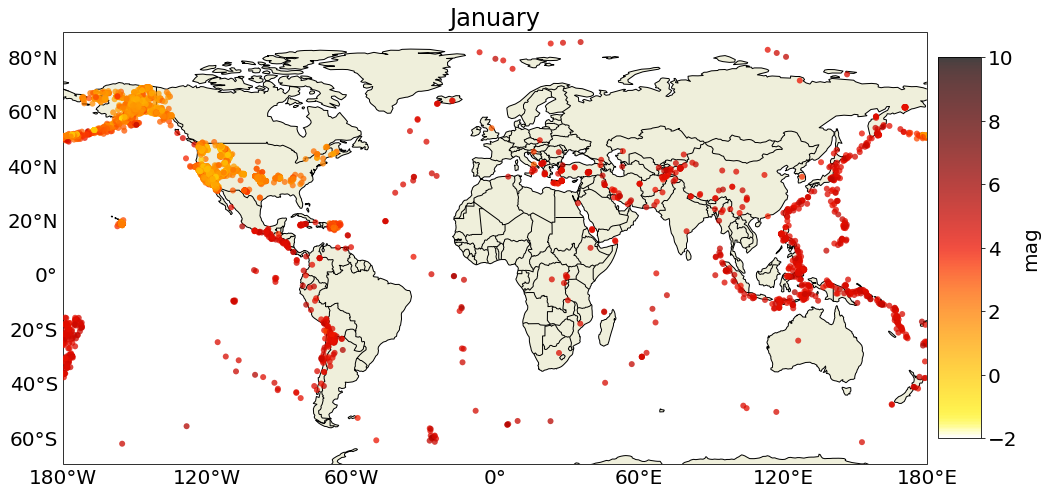

In [32]:
plot_earthquakes(earthquakes, 1).opts(
    fig_inches=(6, 3), aspect=2, fig_size=250, fig_bounds=(0.07, 0.05, 0.87, 0.95)
)

*Tip: One thing that makes working with geospatial data difficult is handling [projections](https://en.wikipedia.org/wiki/Map_projection). When working with datasets that use different projections, GeoViews can help align them &ndash; check out their tutorial [here](https://geoviews.org/user_guide/Projections.html).*

#### 4. Create a mapping of frames to plots using HoloViews.
We will create a `HoloMap` of the frames to include in our animation. This maps the frame to the plot that should be rendered at that frame:

In [33]:
frames = {
    month_num: plot_earthquakes(earthquakes, month_num)
    for month_num in range(1, 13)
}
holomap = hv.HoloMap(frames)

#### 5. Animate the plot.
Now, we will output our `HoloMap` as a GIF animation, which may take a while to run:

:HoloMap   [Default]
   :Overlay
      .Land.I      :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
      .Borders.I   :Feature   [Longitude,Latitude]
      .Points.I    :Points   [longitude,latitude]   (mag)
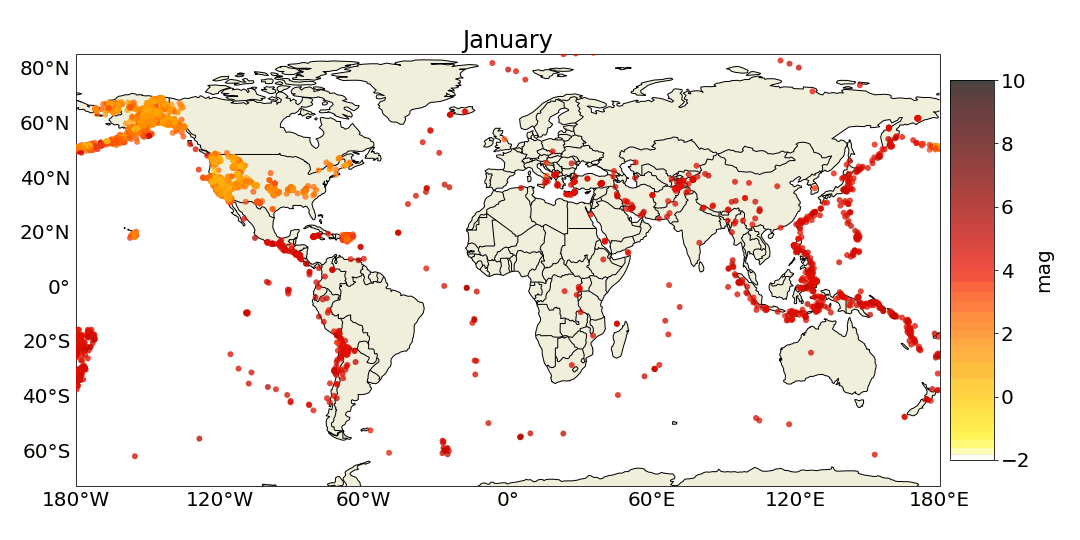

In [34]:
hv.output(
    holomap.opts(
        fig_inches=(6, 3), aspect=2, fig_size=250,
        fig_bounds=(0.07, 0.05, 0.87, 0.95)
    ), holomap='gif', fps=5
)

To save the animation to a file, run the following code:

```python
hv.save(
    holomap.opts(
        fig_inches=(6, 3), aspect=2, fig_size=250,
        fig_bounds=(0.07, 0.05, 0.87, 0.95)
    ), 'earthquakes.gif', fps=5
)
```

### [Exercise 2.2](./workbook.ipynb#Exercise-2.2)

##### Modify the earthquake animation to show earthquakes per day in April 2020.

In [35]:
# Complete this exercise in the `workbook.ipynb` file

In [36]:
# Click on `Exercise 2.2` above to open the `workbook.ipynb` file

## Additional resources

- `matplotlib.animation` [API overview](https://matplotlib.org/stable/api/animation_api.html)
- `FuncAnimation` [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html)
- Matplotlib animation [examples](https://matplotlib.org/stable/api/animation_api.html#examples) 
- Matplotlib's list of [3rd-party animation libraries](https://matplotlib.org/stable/thirdpartypackages/index.html#animations)
- Using HoloViews with the [Matplotlib backend](http://holoviews.org/user_guide/Plotting_with_Matplotlib.html)

## Up Next: [Building Interactive Visualizations for Data Exploration](./3-interactivity.ipynb)